<a href="https://colab.research.google.com/github/pedrobslima/ultrawiki-mining/blob/main/link_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
%%capture
!pip install python-igraph
!pip install pyvis

In [210]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import requests
from http.client import responses
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from pyvis.network import Network
import igraph
from difflib import SequenceMatcher
from IPython.core.display import display, HTML

### Main

In [3]:
main_page_url = "https://ultrakill.wiki.gg/wiki/Main_Page"
domain_url = "https://ultrakill.wiki.gg"
base_url = 'https://ultrakill.wiki.gg/wiki/'

In [108]:
df = DataFrame(columns=['from', 'to'])

In [153]:
def clean_url(url:str):
    url = url.strip() if url is not None else ''
    url = url[:url.find('#')] if '#' in url else url
    return url

def verify_redirect(url:str):
    page = requests.get(url, allow_redirects=True)
    soup = BeautifulSoup(page.content, 'html.parser')
    redirect_links = soup.select('main span[class=mw-redirectedfrom] a')
    if(len(redirect_links) > 0):
        redirect_url = domain_url + redirect_links[0].get('href')
        redirect_page = requests.get(redirect_url)
        soup = BeautifulSoup(redirect_page.content, 'html.parser')
        redr_section = soup.select('ul[class=redirectText] li a')
        true_link = redr_section[0].get('href')
        return domain_url + clean_url(true_link)
    return url

def link_scraping(url:str):
    global df

    if(url in df['from'].values):
        print(f'[{len(df)}] Tentativa de loop: ->{url[31:]}')
    else:
        # Fazer uma solicitação
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')

        # Extrair e armazenar em top_items de acordo com as instruções
        links = soup.select('main a')
        for ahref in links:
            href = clean_url(ahref.get('href'))

            if((href[:6] == '/wiki/') and not(('File:' in href) or ('Special:' in href) or ('ULTRAKILL_Wiki:' in href) or ('Category:' in href) or ('Template:' in href) or ('User:' in href))):
                new_url = domain_url+href
                df = pd.concat([df, DataFrame({'from':url, 'to':new_url}, index=[len(df)])])
                link_scraping(new_url)

In [ ]:
link_scraping(main_page_url)
dfc = df.copy() # caso seja necessário desfazer as modificações no dataset

In [160]:
# removendo loops diretos
df = df[df['from']!=df['to']]

# ordenando strings por linha
df = DataFrame(np.sort(df.values, axis=1), columns=df.columns)

# dicionário para substituir os links que são
# apenas de redirecionamento pelos links reais
uniques = set(df['from'].unique()).union(set(df['to'].unique()))
transform = {}
for link in uniques:
    transform[link] = verify_redirect(link)

# substituição dos links de redirecionamento
df['from'] = df['from'].apply(lambda x: transform[x])
df['to'] = df['to'].apply(lambda x: transform[x])

In [168]:
# removendo loops diretos (dnv)
df = df[df['from']!=df['to']]

# ordenando strings por linha (dnv)
df = DataFrame(np.sort(df.values, axis=1), columns=df.columns)

# agrupando conexões
df['weight'] = 1
df = df.groupby(['from', 'to'], sort=False, as_index=False).sum()

# formatando strings
df['from'] = df['from'].str.replace(base_url, '')
df['to'] = df['to'].str.replace(base_url, '')
df

from           to  weight
0            Main_Page      Weapons       2
1          Spawner_Arm      Weapons       3
2              Sandbox  Spawner_Arm       7
3               Cheats      Sandbox       5
4               Cheats    Hookpoint       3
...                ...          ...     ...
2951              Lore    Main_Page       2
2952           Enemies    Main_Page       2
2953         Main_Page   Soundtrack       2
2954       Development    Main_Page       2
2955  Developer_Museum  Development       1

[2956 rows x 3 columns]

### Grafo

Plot do grafo estático pelo pyplot

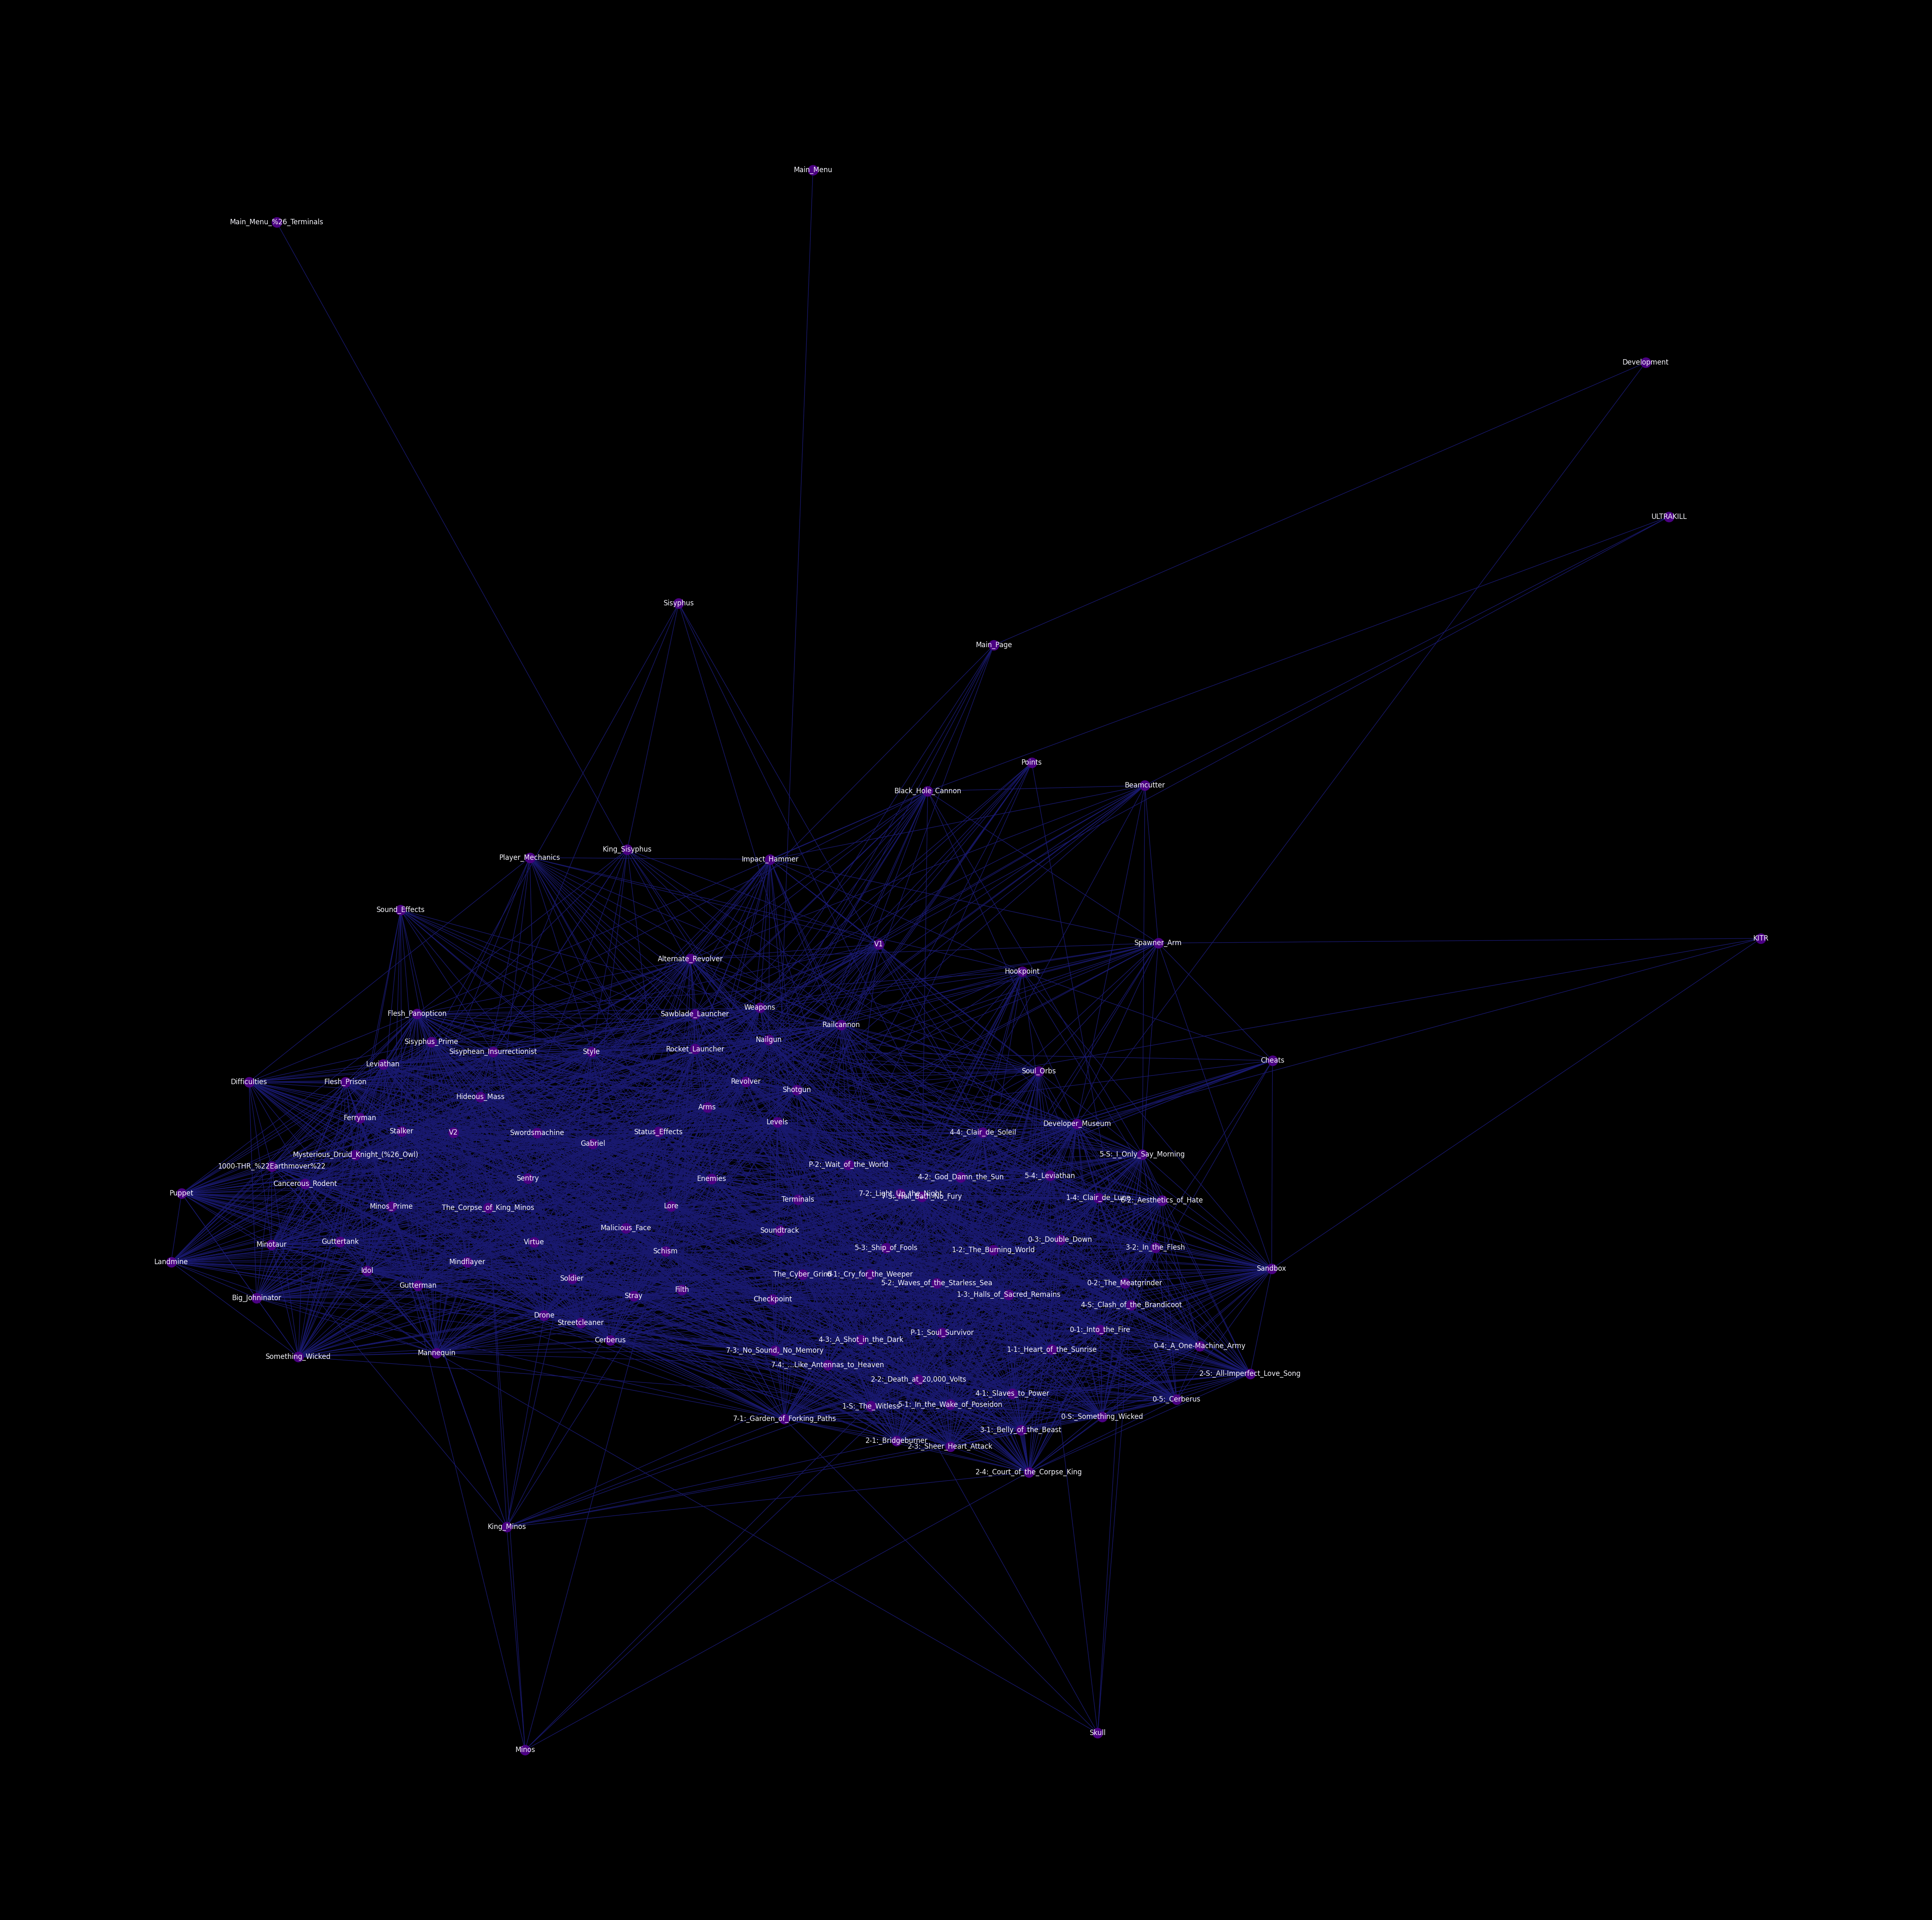

In [242]:
G = nx.from_pandas_edgelist(df, source='from', target='to', edge_attr='weight', create_using=nx.Graph())

fig, ax = plt.subplots(figsize=(60,60))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='indigo', font_color='ghostwhite', edge_color='midnightblue', edge_cmap=plt.cm.Blues, pos=pos)
ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')
plt.show(fig)

---
Plot do gráfico iterativo pelo Networkx

In [199]:
# para que os nós não fiquem mto grandes
node_degree = dict(G.degree)
degrees = MinMaxScaler((1, 10)).fit_transform(np.array(list(node_degree.values())).reshape(-1, 1))
keys = list(node_degree.keys())
for i in range(len(keys)):
    node_degree[keys[i]] = degrees[i]

In [230]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
net.repulsion() # para que os nós não se movam

# Ajustando atributo do tamanho dos nós
nx.set_node_attributes(G, node_degree, 'size')

# Plotando gráfico via html
net.from_nx(G)
net.show("networkx-graph.html")

networkx-graph.html
